# Predictive Analytics 2 - Neural Nets and Regression - Using Python
Instructor(s) - Peter Gedeck

## Solution: Final Assignment
Solution uses Python module pandas and scikit-learn for solving this assigment.

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pylab as plt

from utilities import printConfusionMatrix

DATA = Path('.').resolve().parent / 'data'

## Data preparation

In [2]:
# Load the data
fundraising_df = pd.read_csv(DATA / 'Fundraising.csv')
print(fundraising_df.TARGET_B.value_counts())
meanDonation = fundraising_df[fundraising_df.TARGET_B==1].TARGET_D.mean()
print('Mean donation by donors : ', meanDonation)

1    1560
0    1560
Name: TARGET_B, dtype: int64
Mean donation by donors :  12.999224359


In [3]:
# Prepare data for model building
fundraising_df.drop(columns=['Row Id', 'Row Id.', 'TARGET_D'], inplace=True)
fundraising_df.head()

,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,HV,...,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT,TARGET_B
0,0,1,0,0,1,1,5,1,9,1399,...,703,1,74,102.0,6.0,5.0,29,3,4.857143,1
1,1,0,0,0,1,1,1,0,7,698,...,463,4,46,94.0,12.0,12.0,34,6,9.400000,1
2,0,0,0,1,0,2,5,1,8,828,...,376,13,32,30.0,10.0,5.0,29,7,4.285714,1
3,0,0,0,1,1,1,3,0,4,1471,...,546,4,94,177.0,10.0,8.0,30,3,7.080000,0
4,0,1,0,0,1,1,4,0,8,547,...,432,7,20,23.0,11.0,11.0,30,6,7.666667,0


In [4]:
# Load the data for prediction
futureFundraising_df = pd.read_csv(DATA / 'FutureFundraising.csv')
futureFundraising_df.drop(columns=['Row Id.', 'TARGET_B', 'TARGET_D'], inplace=True)
futureFundraising_df.head(20)

,Row Id,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,...,Icmed,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT
0,1,0,1,0,0,1,1,1,1,8,...,470,452,3,42,92.0,29.0,15.0,17,8,15.333333
1,2,0,0,1,0,0,1,2,1,9,...,489,453,4,21,30.0,20.0,20.0,33,9,15.000000
2,3,0,0,0,1,0,1,1,0,4,...,412,376,10,61,220.0,35.0,25.0,31,9,24.444444
3,4,0,0,0,0,1,1,4,0,1,...,263,283,21,32,41.0,19.0,19.0,31,13,13.666667
4,5,0,0,1,0,1,1,7,1,9,...,793,850,1,47,46.0,10.0,10.0,28,8,5.750000
5,6,0,0,0,1,0,1,2,1,0,...,163,200,47,83,135.0,25.0,0.0,18,1,16.875000
6,7,0,1,0,0,0,1,3,0,9,...,370,380,12,15,20.0,20.0,20.0,33,6,20.000000
7,8,0,1,0,0,1,1,2,1,5,...,347,315,8,64,81.0,5.0,5.0,36,5,2.892857
8,9,0,0,1,0,1,1,7,1,9,...,1000,780,1,25,48.0,15.0,10.0,18,1,9.600000
9,10,0,0,0,1,1,1,4,0,9,...,343,404,6,12,15.0,15.0,15.0,33,6,15.000000


## Step 1: Partitioning

In [5]:
ntotal = len(fundraising_df)
ntrain = round(ntotal * 0.6)
nvalid = ntotal - ntrain

train_df = fundraising_df.sample(n=ntrain, random_state=12345)
valid_df = fundraising_df.drop(train_df.index)
print('Training set:', train_df.shape, 'Validation set:', valid_df.shape)

Training set: (1872, 21) Validation set: (1248, 21)


#### Define helper functions

In [6]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    printConfusionMatrix(train_df['TARGET_B'], 
                         [0 if p < 0.5 else 1 for p in model.predict(train_df.drop(columns=['TARGET_B']))])
    print(title + ' - validation results')
    printConfusionMatrix(valid_df['TARGET_B'], 
                         [0 if p < 0.5 else 1 for p in model.predict(valid_df.drop(columns=['TARGET_B']))])

## Step 2 Model building
### Step 2.1: Logistic regression

In [7]:
logit_reg = sm.GLM(train_df['TARGET_B'], train_df.drop(columns=['TARGET_B']), family=sm.families.Binomial())
logit_result = logit_reg.fit()
confusionMatrices(logit_result, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.5951)

         Prediction
Reference   0   1
        0 523 410
        1 348 591
Logistic regression - validation results
Confusion Matrix (Accuracy 0.5449)

         Prediction
Reference   0   1
        0 308 319
        1 249 372


### Step 2.1: Classification tree

In [8]:
defaultOptions = {'min_samples_split': 20, 'max_depth': 30, 'min_impurity_decrease': 0.01, }

classTree = DecisionTreeClassifier(**defaultOptions)
classTree.fit(train_df.drop(columns=['TARGET_B']), train_df['TARGET_B'])
confusionMatrices(classTree, 'Decision tree')

Decision tree - training results
Confusion Matrix (Accuracy 0.5016)

         Prediction
Reference   0   1
        0   0 933
        1   0 939
Decision tree - validation results
Confusion Matrix (Accuracy 0.4976)

         Prediction
Reference   0   1
        0   0 627
        1   0 621


In [9]:
bagging = BaggingClassifier(DecisionTreeClassifier(**defaultOptions), 
                            max_samples=0.5, max_features=0.5)
bagging.fit(train_df.drop(columns=['TARGET_B']), train_df['TARGET_B'])
confusionMatrices(bagging, 'Bagged Decision tree')

Bagged Decision tree - training results
Confusion Matrix (Accuracy 0.5689)

         Prediction
Reference   0   1
        0 558 375
        1 432 507
Bagged Decision tree - validation results
Confusion Matrix (Accuracy 0.5385)

         Prediction
Reference   0   1
        0 350 277
        1 299 322


In [10]:
adaboost = AdaBoostClassifier(n_estimators=100, base_estimator=DecisionTreeClassifier(**defaultOptions))
adaboost.fit(train_df.drop(columns=['TARGET_B']), train_df['TARGET_B'])
confusionMatrices(adaboost, 'Boosted decision tree')

Boosted decision tree - training results
Confusion Matrix (Accuracy 0.5016)

         Prediction
Reference   0   1
        0   0 933
        1   0 939
Boosted decision tree - validation results
Confusion Matrix (Accuracy 0.4976)

         Prediction
Reference   0   1
        0   0 627
        1   0 621


In [11]:
rfModel = RandomForestClassifier(max_features=3, min_samples_split=300, 
                                 random_state=0, n_estimators=100, criterion='entropy')
rfModel.fit(train_df.drop(columns=['TARGET_B']), train_df['TARGET_B'])
confusionMatrices(rfModel, 'Random forest')

Random forest - training results
Confusion Matrix (Accuracy 0.6255)

         Prediction
Reference   0   1
        0 566 367
        1 334 605
Random forest - validation results
Confusion Matrix (Accuracy 0.5425)

         Prediction
Reference   0   1
        0 317 310
        1 261 360


In [12]:
ldaModel = LinearDiscriminantAnalysis()
ldaModel.fit(train_df.drop(columns=['TARGET_B']), train_df['TARGET_B'])
confusionMatrices(ldaModel, 'Linear discriminant analysis')

Linear discriminant analysis - training results
Confusion Matrix (Accuracy 0.5897)

         Prediction
Reference   0   1
        0 515 418
        1 350 589
Linear discriminant analysis - validation results
Confusion Matrix (Accuracy 0.5465)

         Prediction
Reference   0   1
        0 307 320
        1 246 375


In [13]:
scaleInput = MinMaxScaler()
scaleInput.fit(train_df.drop(columns=['TARGET_B']))

X = scaleInput.transform(train_df.drop(columns=['TARGET_B']))

neuralNet = MLPClassifier(hidden_layer_sizes=(10), activation='logistic', solver='lbfgs', random_state=12)
neuralNet.fit(X, train_df['TARGET_B'])
confusionMatrices(neuralNet, 'Linear discriminant analysis')

Linear discriminant analysis - training results
Confusion Matrix (Accuracy 0.5219)

         Prediction
Reference   0   1
        0 495 438
        1 457 482
Linear discriminant analysis - validation results
Confusion Matrix (Accuracy 0.4936)

         Prediction
Reference   0   1
        0 331 296
        1 336 285


## Step 2.2 Classification under asymmetric response and cost

In this data set, the cases of interest (the "1's") are fairly rare. Since 
sample sizes for training and validating models are limited by the 
algorithms, it is best to have fairly equal numbers of 0's and 1's to give 
the algorithm a good shot at finding out what distinguishes the two classes. 
Think of it this way - if you have 100 1's and 100 0's, adding another 800 0's
is not going to help nearly as much as adding 400 of each.

## Step 2.3 Calculate net profit

The cost for each mailing is \$0.68, donors give on average \$13. This leads to a net profit of \$13.00-\$0.68 for donors and a net loss of \$0.68 for non-donors. 

To take the oversampling into account, we need to adjust the net profit as follows:

Donors: 
$$ ($13.00-$0.68) \frac{5.1\%}{50\%} \approx $1.25664 $$
Non-donors:
$$ -$0.68 \frac{94.9\%}{50\%} \approx -$1.29064 $$

To calculate the lift of the net profit we can define the following function

## Step 2.4 Draw lift curves
To calculate the lift of the net profit we can define the following function

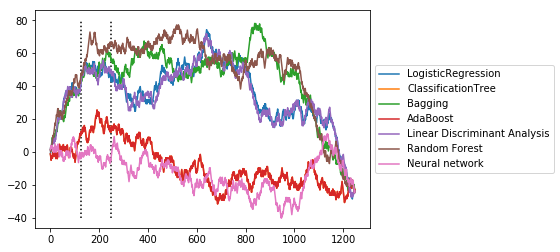

In [14]:
net_profit = [(13 - 0.68)*5.1/50 if respond == 1 else -0.68*94.9/50 for respond in valid_df.TARGET_B]
net_profit = [(13 - 0.68)/9.8 if respond == 1 else -0.68/0.53 for respond in valid_df.TARGET_B]

def liftCurve(prediction):
    df = pd.DataFrame({'netProfit': net_profit, 'prediction': prediction})
    df = df.sort_values(by=['prediction'], ascending=False).reset_index(drop=True)
    return df.netProfit.cumsum()
classTree.predict_proba(valid_df.drop(columns=['TARGET_B']))[:,0]
liftCurve = pd.DataFrame({
    'LogisticRegression': liftCurve(logit_result.predict(valid_df.drop(columns=['TARGET_B']))),
    'ClassificationTree': liftCurve(classTree.predict_proba(valid_df.drop(columns=['TARGET_B']))[:,1]),
    'Bagging': liftCurve(bagging.predict_proba(valid_df.drop(columns=['TARGET_B']))[:,1]),
    'AdaBoost': liftCurve(adaboost.predict_proba(valid_df.drop(columns=['TARGET_B']))[:,1]),
    'Linear Discriminant Analysis': liftCurve(ldaModel.predict_proba(valid_df.drop(columns=['TARGET_B']))[:,1]),
    'Random Forest': liftCurve(rfModel.predict_proba(valid_df.drop(columns=['TARGET_B']))[:,1]),
    'Neural network': liftCurve(neuralNet.predict_proba(valid_df.drop(columns=['TARGET_B']))[:,1]),
})
ax = liftCurve.plot()
ax.vlines(x=[len(valid_df) * 0.1, len(valid_df) * 0.2], ymin=-40, ymax=80, linestyles='dotted')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Based on the lift charts, we would discard the AdaBoost or Neural network classifier. The other classifier perform initially comparable up to about 10% of the dataset (first vertical dashed line). The lift of the random forest classifier then continues to rise, but plateaus before 20% of the list is reached (second vertical dashed line).

Considering these results, we select the random forest model. 

Your result will depend considerably on which of the classifier you chose and how you split your dataset into training and validation. Explore what happens when you vary the random seed in the dataset split. 

# Step 3: Testing
Apply the random forest model to the FutureFundraising.csv dataset.

In [15]:
mailingCandidates = pd.DataFrame({
    'Row Id': futureFundraising_df['Row Id'],
    'prediction': rfModel.predict_proba(futureFundraising_df.drop(columns=['Row Id']))[:,1]
})
mailingCandidates = mailingCandidates.sort_values(by=['prediction'], ascending=False).reset_index(drop=True)
mailingCandidates.head(10)

,Row Id,prediction
0,684,0.663416
1,1645,0.656570
2,966,0.655811
3,165,0.655443
4,1584,0.654460
5,294,0.652763
6,1785,0.650468
7,864,0.649232
8,464,0.647089
9,228,0.646987


Based on these results, you would want to mail to at least 10% of the list - we are pretty confident of increasing profit to that point.  Mailing to more than 20% of the list seems counterproductive.  Business considerations (e.g. resources available, aggressiveness of profit targets, etc.) could govern a choice within the 10% - 20% range.